# Logistic Regression vs. Bayesian Classifier

Environment: R 3.6.1 and Jupyter notebook

Libraries used:
* dplyr
* Matrix
* mvtnorm
* reshape2
* ggplot2

## Introduction

In this notebook, the algorithms of Logistic Regression and Bayesian Classifier will be implemented. After the implementation, the test error for these 2 models need to be calculated when the train data size is from the sequence, which is 5, 10, 15, 20, ... until all train data are used. The test error will be visualized to examine the relation between test error and training data size.

## Import libraries

In [1]:
options(warn=-1)

library(dplyr)
library(Matrix)
library(mvtnorm)
library(reshape2)
library(ggplot2)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


In [2]:
read_data <- function(fname, sc) {
  data <- read.csv(file = fname, head = TRUE, sep = ",")
  nr = dim(data)[1]
  nc = dim(data)[2]
  x = data[1:nr, 1:(nc - 1)]
  y = data[1:nr, nc]
  if (isTRUE(sc)) {
    x = scale(x)
    y = scale(y)
  }
  return(list("x" = x, "y" = y))
}

## Import data

In [3]:
# load data and transform the labels as binary boolean
train_data <- read_data("train5.csv", FALSE)
x_train <- train_data$x
y_train <- train_data$y == 1

test_data <- read_data("test5.csv", FALSE)
x_test <- test_data$x
y_test <- test_data$y == 1

## Implement logistic regression

The `LogisticRegression` class is similar to `Perceptron` class, as the algorithm of logistic regression algorithm training is similar to the perceptron. Both of them using mini-batch gradient descent to train the model, so most code of `LogisticRegression` is from the `Perceptron`.

There are some different places. 
1. The `LogisticRegression` drops all code related to multi-class.
2. The `loss` function is changed to the loss function of logistic regression rather than perceptron.
3. The gradient descent process is changed for logistic regression

In [4]:
LogisticRegression <- setRefClass("LogisticRegression",
                                  fields = list(w = "Matrix", b = "numeric", history = "data.frame"), methods = list(
    fit = function(x, y, epochs, batch_size = 1, validation_data = NULL, learning_rate_decay = 1,
                   learning_rate = 0.01, shuffle = TRUE, history_per_step = FALSE) {
      # divide the data as batches
      batches <- .self$preprocess(x, y, batch_size, shuffle)

      fit_each_epoch <- function(epoch) {
        fit_each_batch <- function(batch) {
          # reformat the x y dataframe as matrix for computation
          if (batch_size == 1) {
            x_batch <- t(Matrix(batch$x))
            y_batch <- Matrix(batch$y)
          } else {
            x_batch <- Matrix(batch$x)
            y_batch <- Matrix(batch$y)
          }
          # predict the data is belonged to which class
          y_hat <- .self$predict(x_batch)
          # locate the misclassified index
          misclassified_index <- (y_hat != y_batch) %>% as.vector
          y_mask <- y_batch - y_hat
          # training, if all the prediction match, skip.
          if (sum(misclassified_index) != 0) {
            # vectorized calculation of the gradient by grad(w) = xy, and grad(b) = y
            grad_w <- (t(x_batch) %*% y_mask) / batch_size
            grad_b <- colMeans(y_mask %>% Matrix) * batch_size / sum(misclassified_index)

            # apply the gradient descent
            .self$w <- .self$w - learning_rate * grad_w
            .self$b <- .self$b - learning_rate * grad_b
          }

          # generate history data for weights and error of given test data
          if (is.null(validation_data)) c(.self$b, as.vector(.self$w))
          else {
            x_test <- validation_data[[1]]
            y_test <- validation_data[[2]]
            test_error <- .self$loss(x_test, y_test)
            # stack the b and w, as the weights history for output
            weights <- rbind(.self$b, .self$w)
            # flatten the matrix as a vector and concat the test_error for output
            c(as.vector(weights), test_error)
          }
        }
        # if the learning_rate_decay is set,
        # here it can apply learning rate decay.
        if (learning_rate_decay != 1) {
          learning_rate <<- learning_rate * learning_rate_decay
        }
        # apply the function above and return the history of this epoch
        batch_history <- lapply(batches, fit_each_batch)
        # output the history by each epoch or by each step(mini-batch)
        if (history_per_step) batch_history
        else batch_history[[length(batch_history)]]
      }
      # reformat the history data frame
      if (history_per_step) {
        # get history from training on each epoch, and combine as a data frame
        weight_history <- 1:epochs %>% lapply(fit_each_epoch) %>%
          unlist(recursive = FALSE) %>% Reduce(f = rbind) %>% as.data.frame
        # generate column names and set
        col_names <- c("step", .self$get_history_names(x, y, validation_data))
        # add step/epoch and colnames for the history data
        .self$history <- cbind(1:nrow(weight_history), weight_history) %>% `colnames<-`(col_names)
        .self
      } else {
        # reformat the history data if only logged on epoch
        weight_history <- as.data.frame(t(sapply(1:epochs, fit_each_epoch)))
        col_names <- c("epoch", .self$get_history_names(x, y, validation_data))
        .self$history <- cbind(1:epochs, weight_history) %>% `colnames<-`(col_names)
        .self
      }

    },

    predict = function(x, threshold = 0.5) {
      z <- data.matrix(x) %*% .self$w + .self$b
      .self$sigmoid(z) > threshold
    },

    sigmoid = function(z) (1 / (1 + exp(z))),

    loss = function(x, y) {
      # this function is for computing the loss with the x y data given
      z <- .self$predict(x)
      a <- .self$sigmoid(z)
      a[!y] <- 1 - a[!y]
      sum(a)
    },

    preprocess = function(x, y, batch_size, shuffle = TRUE) {
      # this function is for preprocessing the data frame input
      x_len <- nrow(x)
      if (!class(y) %in% c("data.frame", "matrix", "Matrix")) y <- Matrix(y)
      n_classes <- ncol(y)
      # if fit in the first time, initialize the weights
      if (.self$w %>% length == 0) {
        .self$w <- Matrix(runif(ncol(x) * n_classes), ncol = n_classes)
        .self$b <- runif(n_classes)
      }
      # if shuffle applied, shuffle the data
      if (shuffle) {
        index <- sample(1:x_len, x_len, replace = FALSE)
        x <- x[index,]
        y <- y[index,]
      }
      # divide the data
      batches <- .self$to_batches(x, y, batch_size)
      batches
    },

    get_history_names = function(x, y, validation_data = NULL) {
      # this function for generate the column names of history data
      # generate weight column names
      col_names <- {
        w_names <- sapply(1:ncol(x), function(i) paste0("w", i))
        c("b", w_names)
      }
      # generate test_error column names if needed
      if (is.null(validation_data)) col_names
      else c(col_names, "test_error")
    },
                          
    to_batches = function(x, y, batch_size) {
      # this function is for divide the data as batches
      # as the batches are not divided equally, so there are complete batches,
      # and a residual batch.
      x <- as.matrix(x)
      y <- as.matrix(y)
      x_nrow <- nrow(x)
      # the number of complete batches
      complete_batch_num <- floor(x_nrow / batch_size)
      # The last row of complete batches
      complete_nrow <- complete_batch_num * batch_size
      # locate the residual part
      if (complete_nrow == x_nrow) {
        x_residual <- NULL
        y_residual <- NULL
        batch_nums <- complete_batch_num
      } else {
        x_residual <- x[(complete_nrow + 1):x_nrow,]
        y_residual <- y[(complete_nrow + 1):x_nrow,]
        batch_nums <- complete_batch_num + 1
      }
      # get residual batch data
      residual_nrow <- x_nrow - complete_nrow
      if (residual_nrow == 1) {
        x_residual <- t(x_residual)
        y_residual <- t(y_residual)
      }
      # locate and get other batches
      lapply(1:batch_nums, function(i) {
        start_index <- (i - 1) * batch_size + 1
        if (start_index + batch_size - 1 <= x_nrow) {
          list(x = x[start_index:(start_index + batch_size - 1),],
               y = y[start_index:(start_index + batch_size - 1),])
        } else {
          list(x = x_residual, y = y_residual)
        }
      })
    }
  )
)

## Implement bayesian classifier

The `BayesianClassifier` class will be implemented in this section for binary classification. The bayesian classifier algorithm is for predicting the data by the bayesian theory, which is $$
p(C|x) \propto p(x|C)p(C)
$$ 

The `BayesianClassifier` class contains:
* fields:
    * `p0`: The value of $p(C=0)$
    * `p1`: The value of $p(C=1)$
    * `mu0`: The value of $\mu_0$, which is the mean of $x$ for $C=0$
    * `mu1`: The value of $\mu_1$, which is the mean of $x$ for $C=1$
    * `sigma`: The value of the shared covariance
    
* methods:
    * `fit`: The method of the model fitting the train data
    * `predict`: The method of predict the given x (test data) 
    * `loss`: The loss function to calculate the error

In [5]:
BayesianClassifier <- setRefClass("BayesianClassifier",
                                  fields = c("p0", "p1", "mu0", "mu1", "sigma"), methods = list(
  fit = function(x, y) {
    # calculate p(c) for 2 classes
    .self$p0 <- 1 - sum(y) / length(y)
    .self$p1 <- 1 - .self$p0
    # calculate mu for 2 classes
    .self$mu0 <- colMeans(x[!y,])
    .self$mu1 <- colMeans(x[y,])
    # calculate the shared variance
    sigma0 <- var(x[!y,])
    sigma1 <- var(x[y,])
    .self$sigma <- p0 * sigma0 + p1 * sigma1
    .self
  },

  predict = function(x) {
    posterior0 <- .self$p0 * dmvnorm(x = x, mean = .self$mu0, sigma = .self$sigma)
    posterior1 <- .self$p1 * dmvnorm(x = x, mean = .self$mu1, sigma = .self$sigma)
    ifelse(posterior0 > posterior1, 0, 1)
  },

  loss = function(x, y) {
    y_hat <- .self$predict(x)
    sum(y != y_hat) / length(y)
  }
))

## Visualization

In this section, the visualization of train error and test error for each specified train data size is plotted.

In [6]:
# set data amounts sequence which starts from 5 and increases with step = 5
sizes <- seq(5, nrow(x_train), 5)

# wrap the function for calculate the error 
get_logistic_regression_error <- function(size) {
  # bgd for logistic regression
  iter <- 10
  batch_size <- size
  epochs <- iter / ceiling(size/batch_size)
  model <- LogisticRegression()$fit(x_train[1:size,], y_train[1:size], epochs = epochs,
                                    batch_size = batch_size, validation_data = NULL, learning_rate_decay = 0.99,
                                    learning_rate = 1.0, shuffle = TRUE, history_per_step = FALSE)
  # return training error and test error  
  c(sum(model$predict(x_train[1:size,]) != y_train[1:size]) / size,
    sum(model$predict(x_test) != y_test) / length(y_test))
}

get_bayesian_classifier_error <- function(size) {
  # get bc error with given size  
  model <- BayesianClassifier()$fit(x_train[1:size,], y_train[1:size])
  c(model$loss(x_train[1:size,], y_train[1:size]), 
    model$loss(x_test, y_test))
}

In [7]:
# time comsumption: about 10 seconds
set.seed(5201)
# train model and get errors
lr_error <- sizes %>% lapply(get_logistic_regression_error) %>% Reduce(f = rbind)
bc_error <- sizes %>% lapply(get_bayesian_classifier_error) %>% Reduce(f = rbind)
error_df <- data.frame(size = sizes, lr = lr_error, bc = bc_error) %>% 
  `colnames<-`(c("size", "lr_train", "lr_test", "bc_train", "bc_test"))

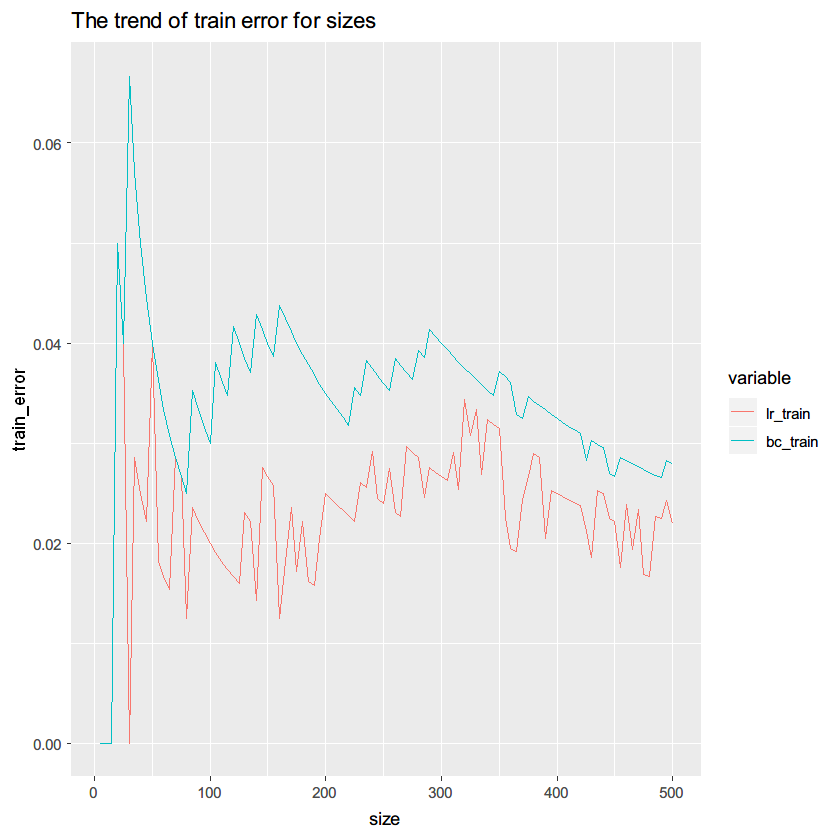

In [8]:
error_df_melt <- melt(error_df, id.vars = c("size"))
# plot train error
ggplot(error_df_melt %>% filter(variable %in% c("lr_train", "bc_train"))) + 
  geom_line(aes(x=size, y=value, color = variable)) +
  xlab("size") + ylab("train_error") + 
  ggtitle("The trend of train error for sizes")

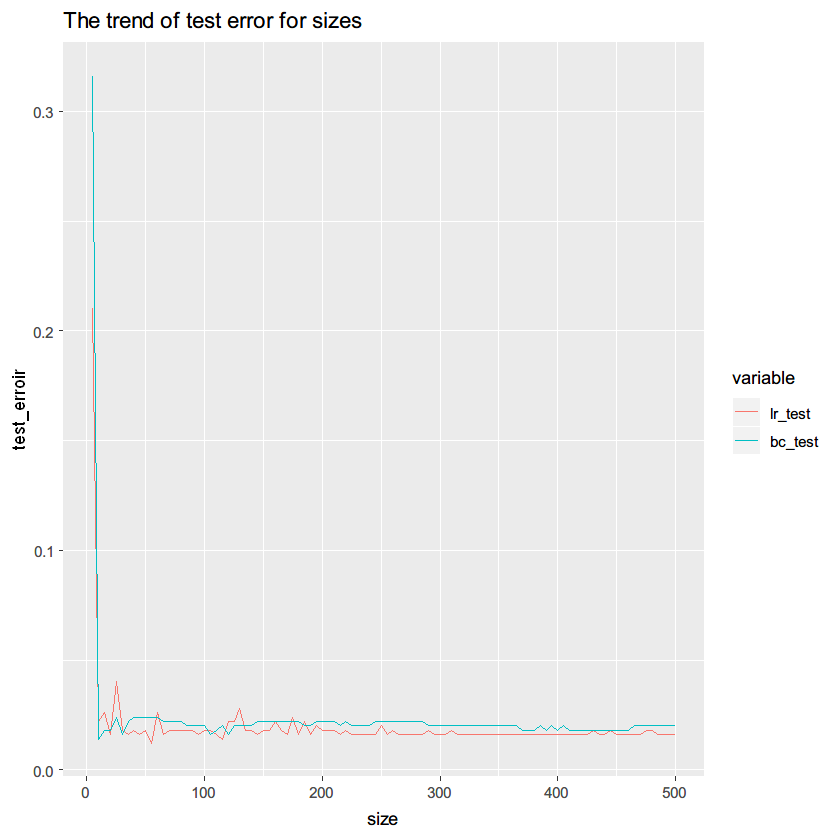

In [9]:
# plot test error
ggplot(error_df_melt %>% filter(variable %in% c("lr_test", "bc_test"))) + 
  geom_line(aes(x=size, y=value, color = variable)) +
  xlab("size") + ylab("test_erroir") + 
  ggtitle("The trend of test error for sizes")

When the size of training data is increased, both the logistic regression and the bayesian classifier keep stable in training error with several fluctuations. The test error will suddenly drop when size is very small, then keep stable when the size is increased.

When the training set is small, the bayesian classifier is better as the test error of bayesian classifier is lower than logistic regression when the size is larger than 5 and smaller than 20. When the data set is large, the test error of bayesian classifier is higher than logistic regression, so the logistic regression is better suited.

When the training set is small, the logistic regression will cause more overfitting than the bayesian classifier, so bayesian is better when the training set is small. When the training set is large, the logitic regression might not be overfitting, because more data can reduce the overfitting situation, so the performance of logitic regression will be better than bayesian classifier.